In [24]:
from astropy.io import fits
from astropy.time import Time
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as pl
import mpl_defaults as mpld
import theano.tensor as tt
from SpecGP.terms import KroneckerTerm
from SpecGP.distributions import MvUniform
from SpecGP.means import KroneckerConstant
import pymc3 as pm
%matplotlib inline

In [25]:
# source: https://sohowww.nascom.nasa.gov/data/archive.html
blue = fits.open('soho/blue.fits')
green = fits.open('soho/green.fits')
red = fits.open('soho/red.fits')

r, g, b = red[0].data, green[0].data, blue[0].data
mask = np.isfinite(r) & np.isfinite(g) & np.isfinite(b)
start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, len(r)) - start
r, g, b = r[mask].astype('float64'), g[mask].astype('float64'), b[mask].astype('float64')
t = t[mask]
flux = np.sum([r, g, b], axis=0)/3

In [26]:
i = 58273
di = 3000
t = t[i:i+di]# * 60

add_wn = np.exp(-4)
wn = np.random.randn(3, len(t))*add_wn

r, g, b = r[i:i+di]/1e3 + wn[0], g[i:i+di]/1e3 + wn[1], b[i:i+di]/1e3 + wn[2]

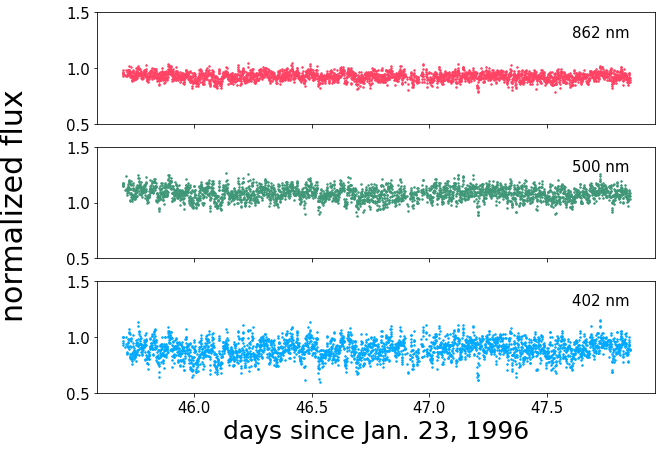

In [27]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+r, '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+g, '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+b, '.', color=mpld.blue, alpha=1, ms=3.0)

ax[0].annotate('862 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('500 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('402 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

[ax.set_ylim(0.5, 1.5) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.3), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)
pl.savefig("/Users/tgordon/Desktop/spm_lc.pdf")

In [6]:
y = np.vstack((r, g, b)).T.reshape(3*len(t),)
    
with pm.Model() as model:
    
    logS0 = MvUniform("logS0", lower=[-20]*3, upper=[0.0]*3, testval=[-6, -15, -17])
    logw = MvUniform("logw", lower=[-3, 5, 7], upper=[1, 7, 10], testval=[-1, 6.5, 7.5])
    logQ = pm.Uniform("logQ", lower=0.0, upper=3.0, testval=1.5)
    alpha1 =  MvUniform("alpha1", lower=[0]*3, upper=[2]*3, testval=[0.5]*3)
    alpha2 =  MvUniform("alpha2", lower=[0]*3, upper=[2]*3, testval=[0.5]*3)
    mean = MvUniform("mean", lower=[-1]*3, upper=[1]*3, testval=tt.mean([r, g, b], axis=1))
    logsig = MvUniform("logsig", lower=[-15]*3, upper=[0.0]*3, testval=[-4]*3)
    
    term0 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[0],
        log_w0 = logw[0],
        log_Q = -np.log(np.sqrt(2))
    )
    term1 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[1],
        log_w0 = logw[1],
        log_Q = -np.log(np.sqrt(2))
    )
    term2 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[2],
        log_w0 = logw[2],
        log_Q = logQ
    )
        
    q0 = tt.exp(tt.stack([0.0, alpha1[0], alpha2[0]]))
    q1 = tt.exp(tt.stack([0.0, alpha1[1], alpha2[1]]))
    q2 = tt.exp(tt.stack([0.0, alpha1[2], alpha2[2]]))
        
    kernel = (KroneckerTerm(term0, q0) + 
              KroneckerTerm(term1, q1) + 
              KroneckerTerm(term2, q2))
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=6, mean=KroneckerConstant(mean))
    gp.marginal("gp", observed = y)
        
    start = model.test_point
    map_soln = None
    map_soln = xo.optimize(start=start, verbose=True)
    start = map_soln
    trace = pm.sample(
        tune=500,
        draws=500,
        start=start,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

optimizing logp for variables: [logsig, mean, alpha2, alpha1, logQ, logw, logS0]


message: Desired error not necessarily achieved due to precision loss.
logp: 21623.880449237917 -> 25090.02157118075
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, mean, alpha2, alpha1, logQ, logw, logS0]
Sampling 2 chains, 929 divergences: 100%|██████████| 2000/2000 [11:53<00:00,  3.45draws/s]
There were 452 divergences after tuning. Increase `target_accept` or reparameterize.
There were 475 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7867225684329067, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
map_soln

{'logS0': array([ -9.59731017, -12.81914538, -16.94433743]),
 'logw': array([1.91034322, 6.24808005, 7.40342787]),
 'logQ_interval__': array(-0.69883667),
 'alpha1': array([0.55951987, 0.58791495, 0.56431476]),
 'alpha2': array([0.01461041, 0.95780865, 0.95643909]),
 'mean': array([-0.08069726,  0.06689452, -0.11886708]),
 'logsig': array([-3.97813032, -3.93416698, -3.94049677]),
 'logQ': array(0.99621061)}

In [11]:
def get_kernel(d):
    
    logw = d["logw"]
    logQ = d["logQ"]
    logS0 = d["logS0"]
    ldg = d["alpha1"]
    ldb = d["alpha2"]
    
    term0 = xo.gp.terms.SHOTerm(
            log_S0 = logS0[0],
            log_w0 = logw[0],
            log_Q = -np.log(np.sqrt(2))
    )
    term1 = xo.gp.terms.SHOTerm(
            log_S0 = logS0[1],
            log_w0 = logw[1],
            log_Q = -np.log(np.sqrt(2))
    )
    term2 = xo.gp.terms.SHOTerm(
            log_S0 = logS0[2],
            log_w0 = logw[2],
            log_Q = logQ
    )

    q0 = tt.exp(tt.stack([0.0, ldg[0], ldb[0]]))
    q1 = tt.exp(tt.stack([0.0, ldg[1], ldb[1]]))
    q2 = tt.exp(tt.stack([0.0, ldg[2], ldb[2]]))
                
    kernel = (KroneckerTerm(term0, q0) + 
              KroneckerTerm(term1, q1) + 
              KroneckerTerm(term2, q2))
                
    return kernel

In [12]:
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fftr = np.fft.rfft(r)
fftg = np.fft.rfft(g)
fftb = np.fft.rfft(b)

fftr *= np.conj(fftr)
fftg *= np.conj(fftg)
fftb *= np.conj(fftb)

powerfftr = fftr.real / len(t)**2
powerfftg = fftg.real / len(t)**2
powerfftb = fftb.real / len(t)**2

In [13]:
kernel = get_kernel(map_soln)
psd = kernel.psd(2*np.pi*f).T.eval()

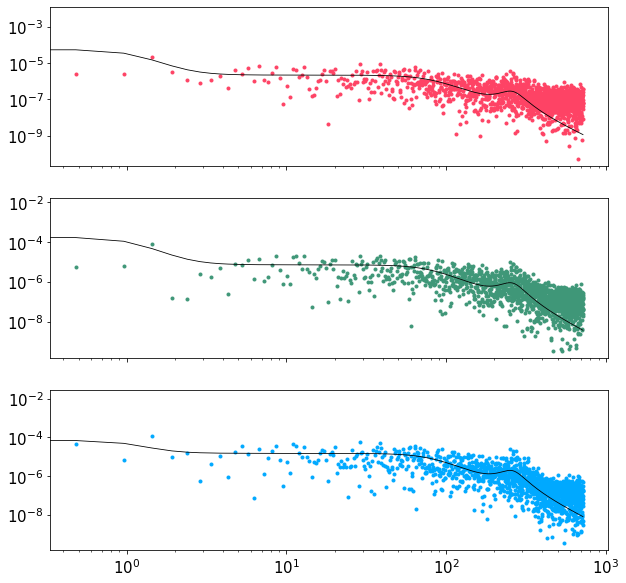

In [14]:
fig, ax = pl.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].loglog(f, powerfftr, '.', color=mpld.red)
ax[1].loglog(f, powerfftg, '.', color=mpld.green)
ax[2].loglog(f, powerfftb, '.', color=mpld.blue)

ax[0].loglog(f, psd[0], color='k', linewidth=0.8)
ax[1].loglog(f, psd[1], color='k', linewidth=0.8)
ax[2].loglog(f, psd[2], color='k', linewidth=0.8)

In [15]:
m = 3
gp = xo.gp.GP(kernel, t, np.exp(-10)*np.ones((m, len(t))) ** 2, J=6)
z = gp.dot_l(np.random.randn(m*len(t), 1)).eval()

Text(0.0, 0.3, 'normalized flux')

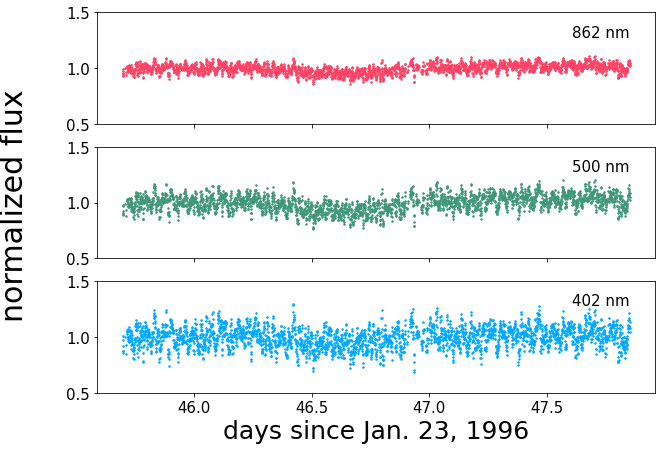

In [16]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+z[::3], '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+z[1::3], '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+z[2::3], '.', color=mpld.blue, alpha=1, ms=3.0)

ax[0].annotate('862 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('500 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('402 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

[ax.set_ylim(0.5, 1.5) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.3), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)

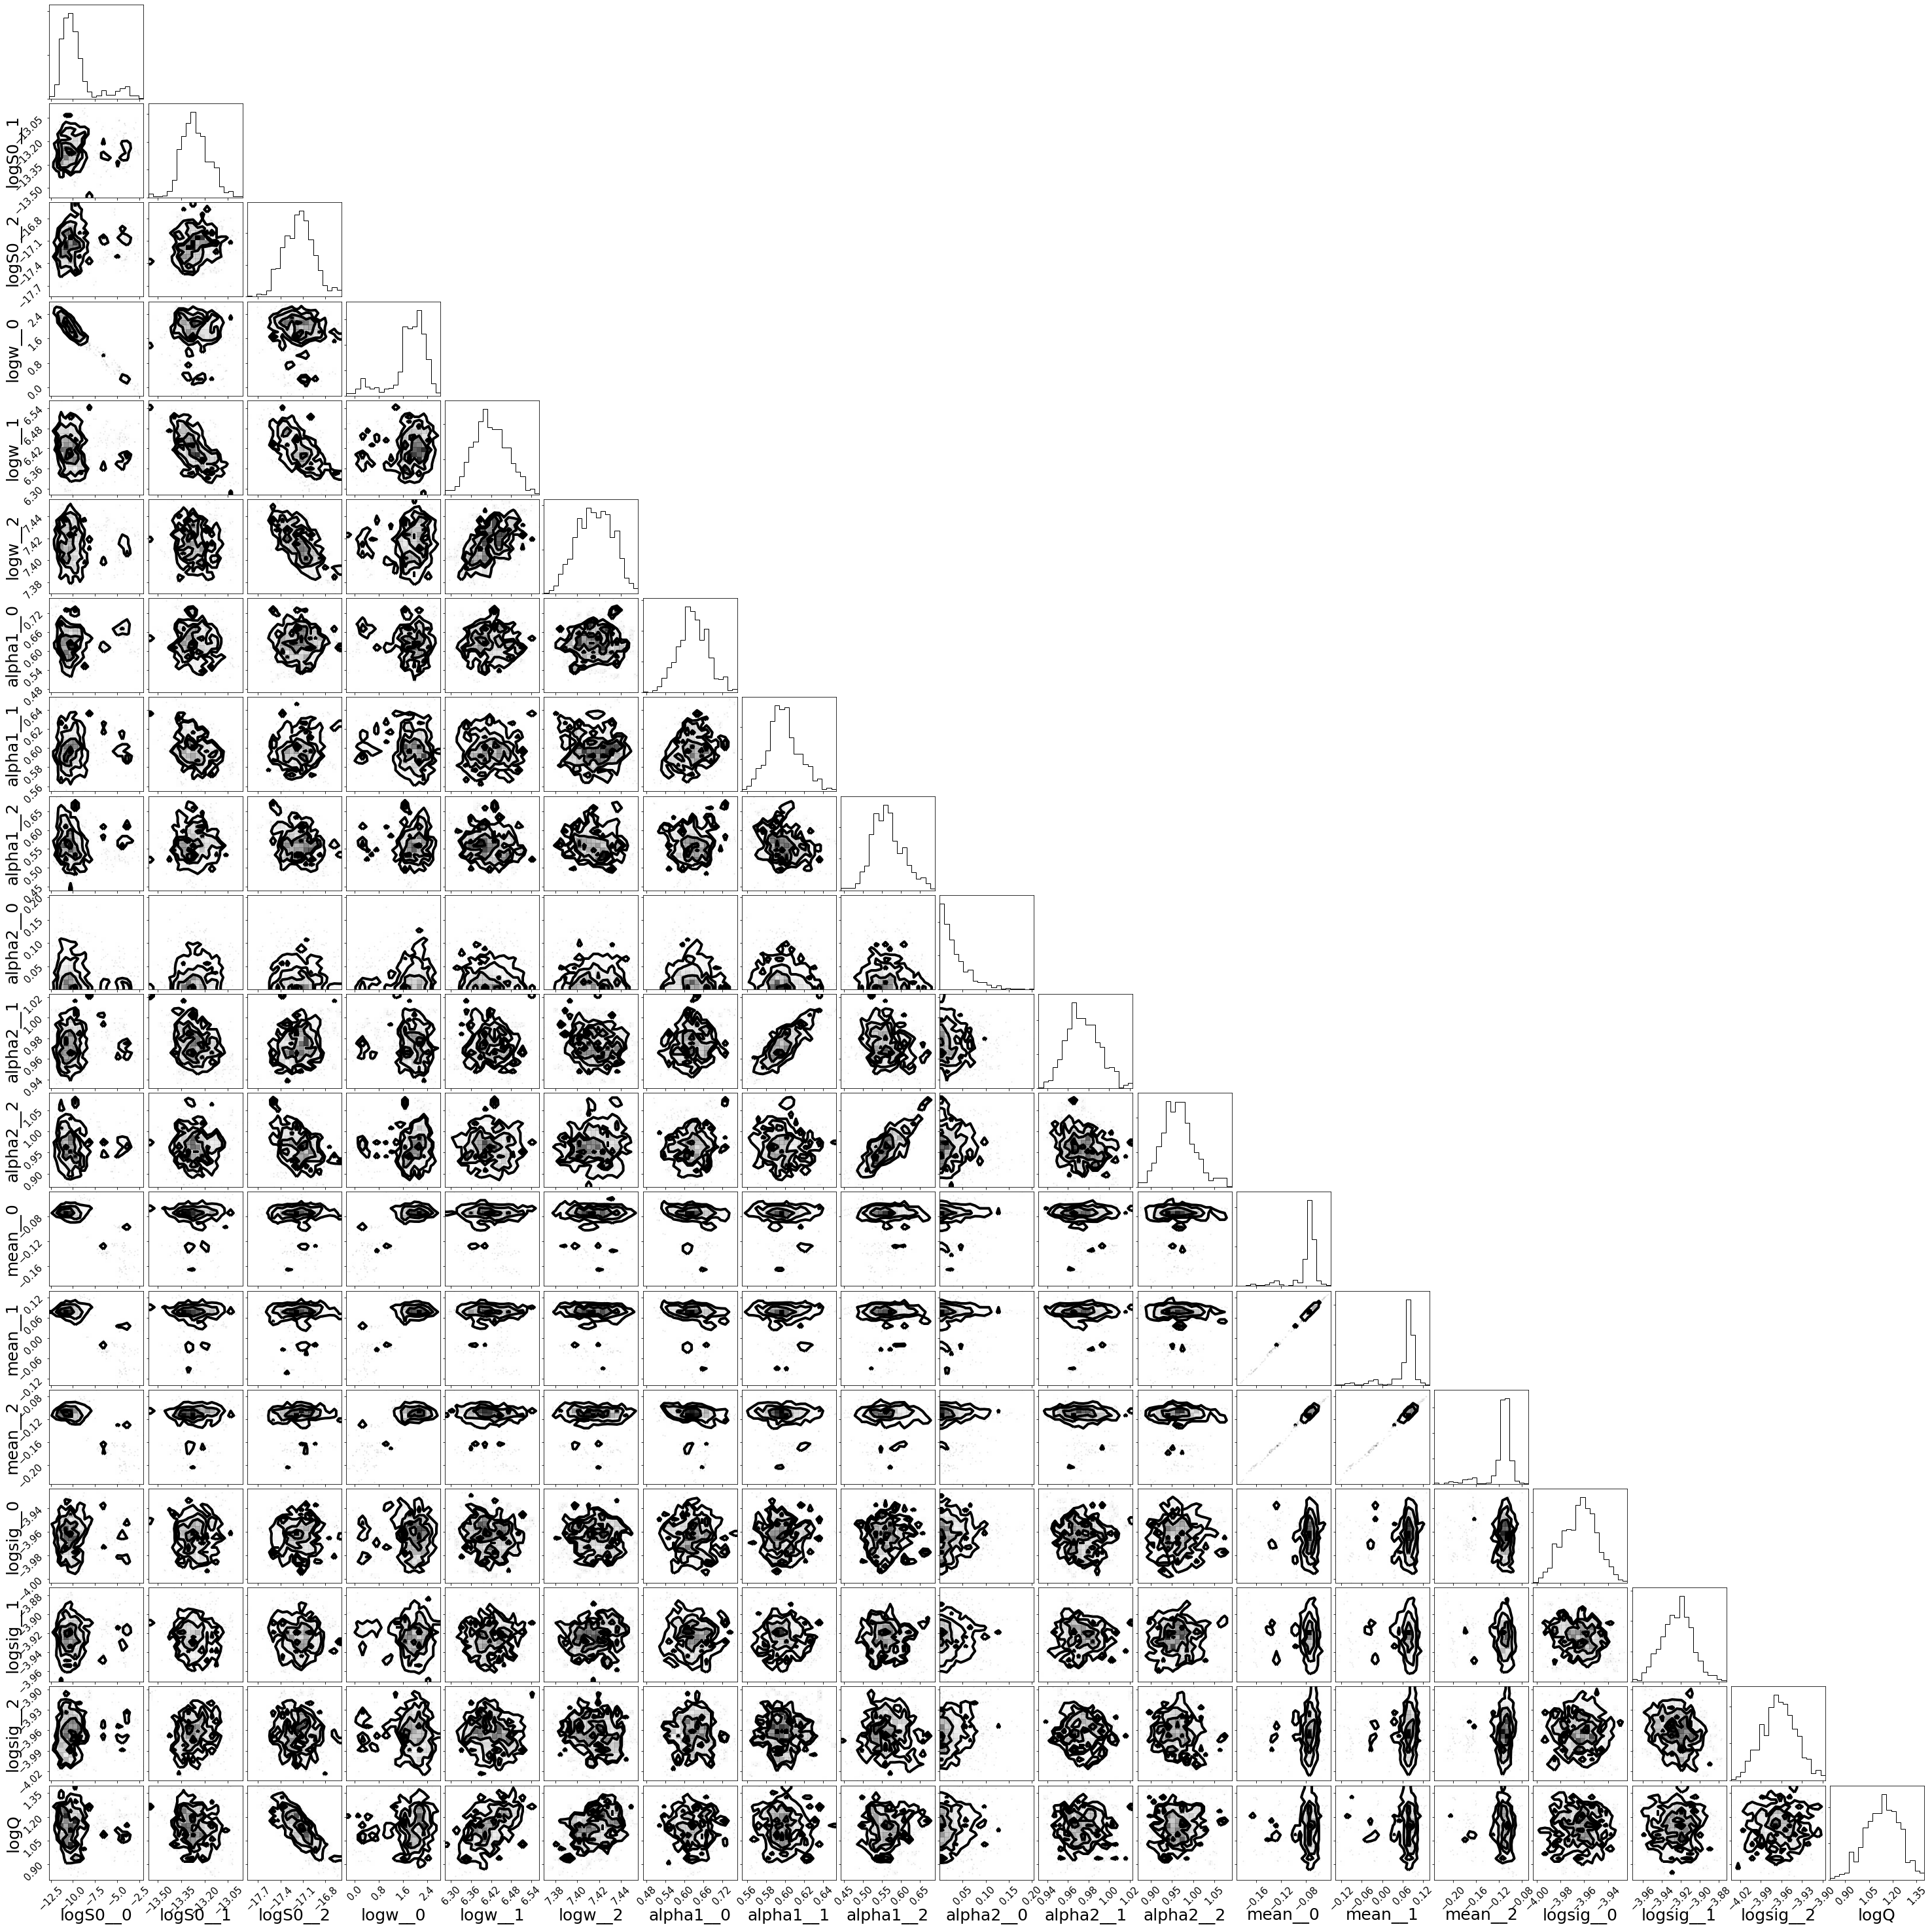

In [17]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

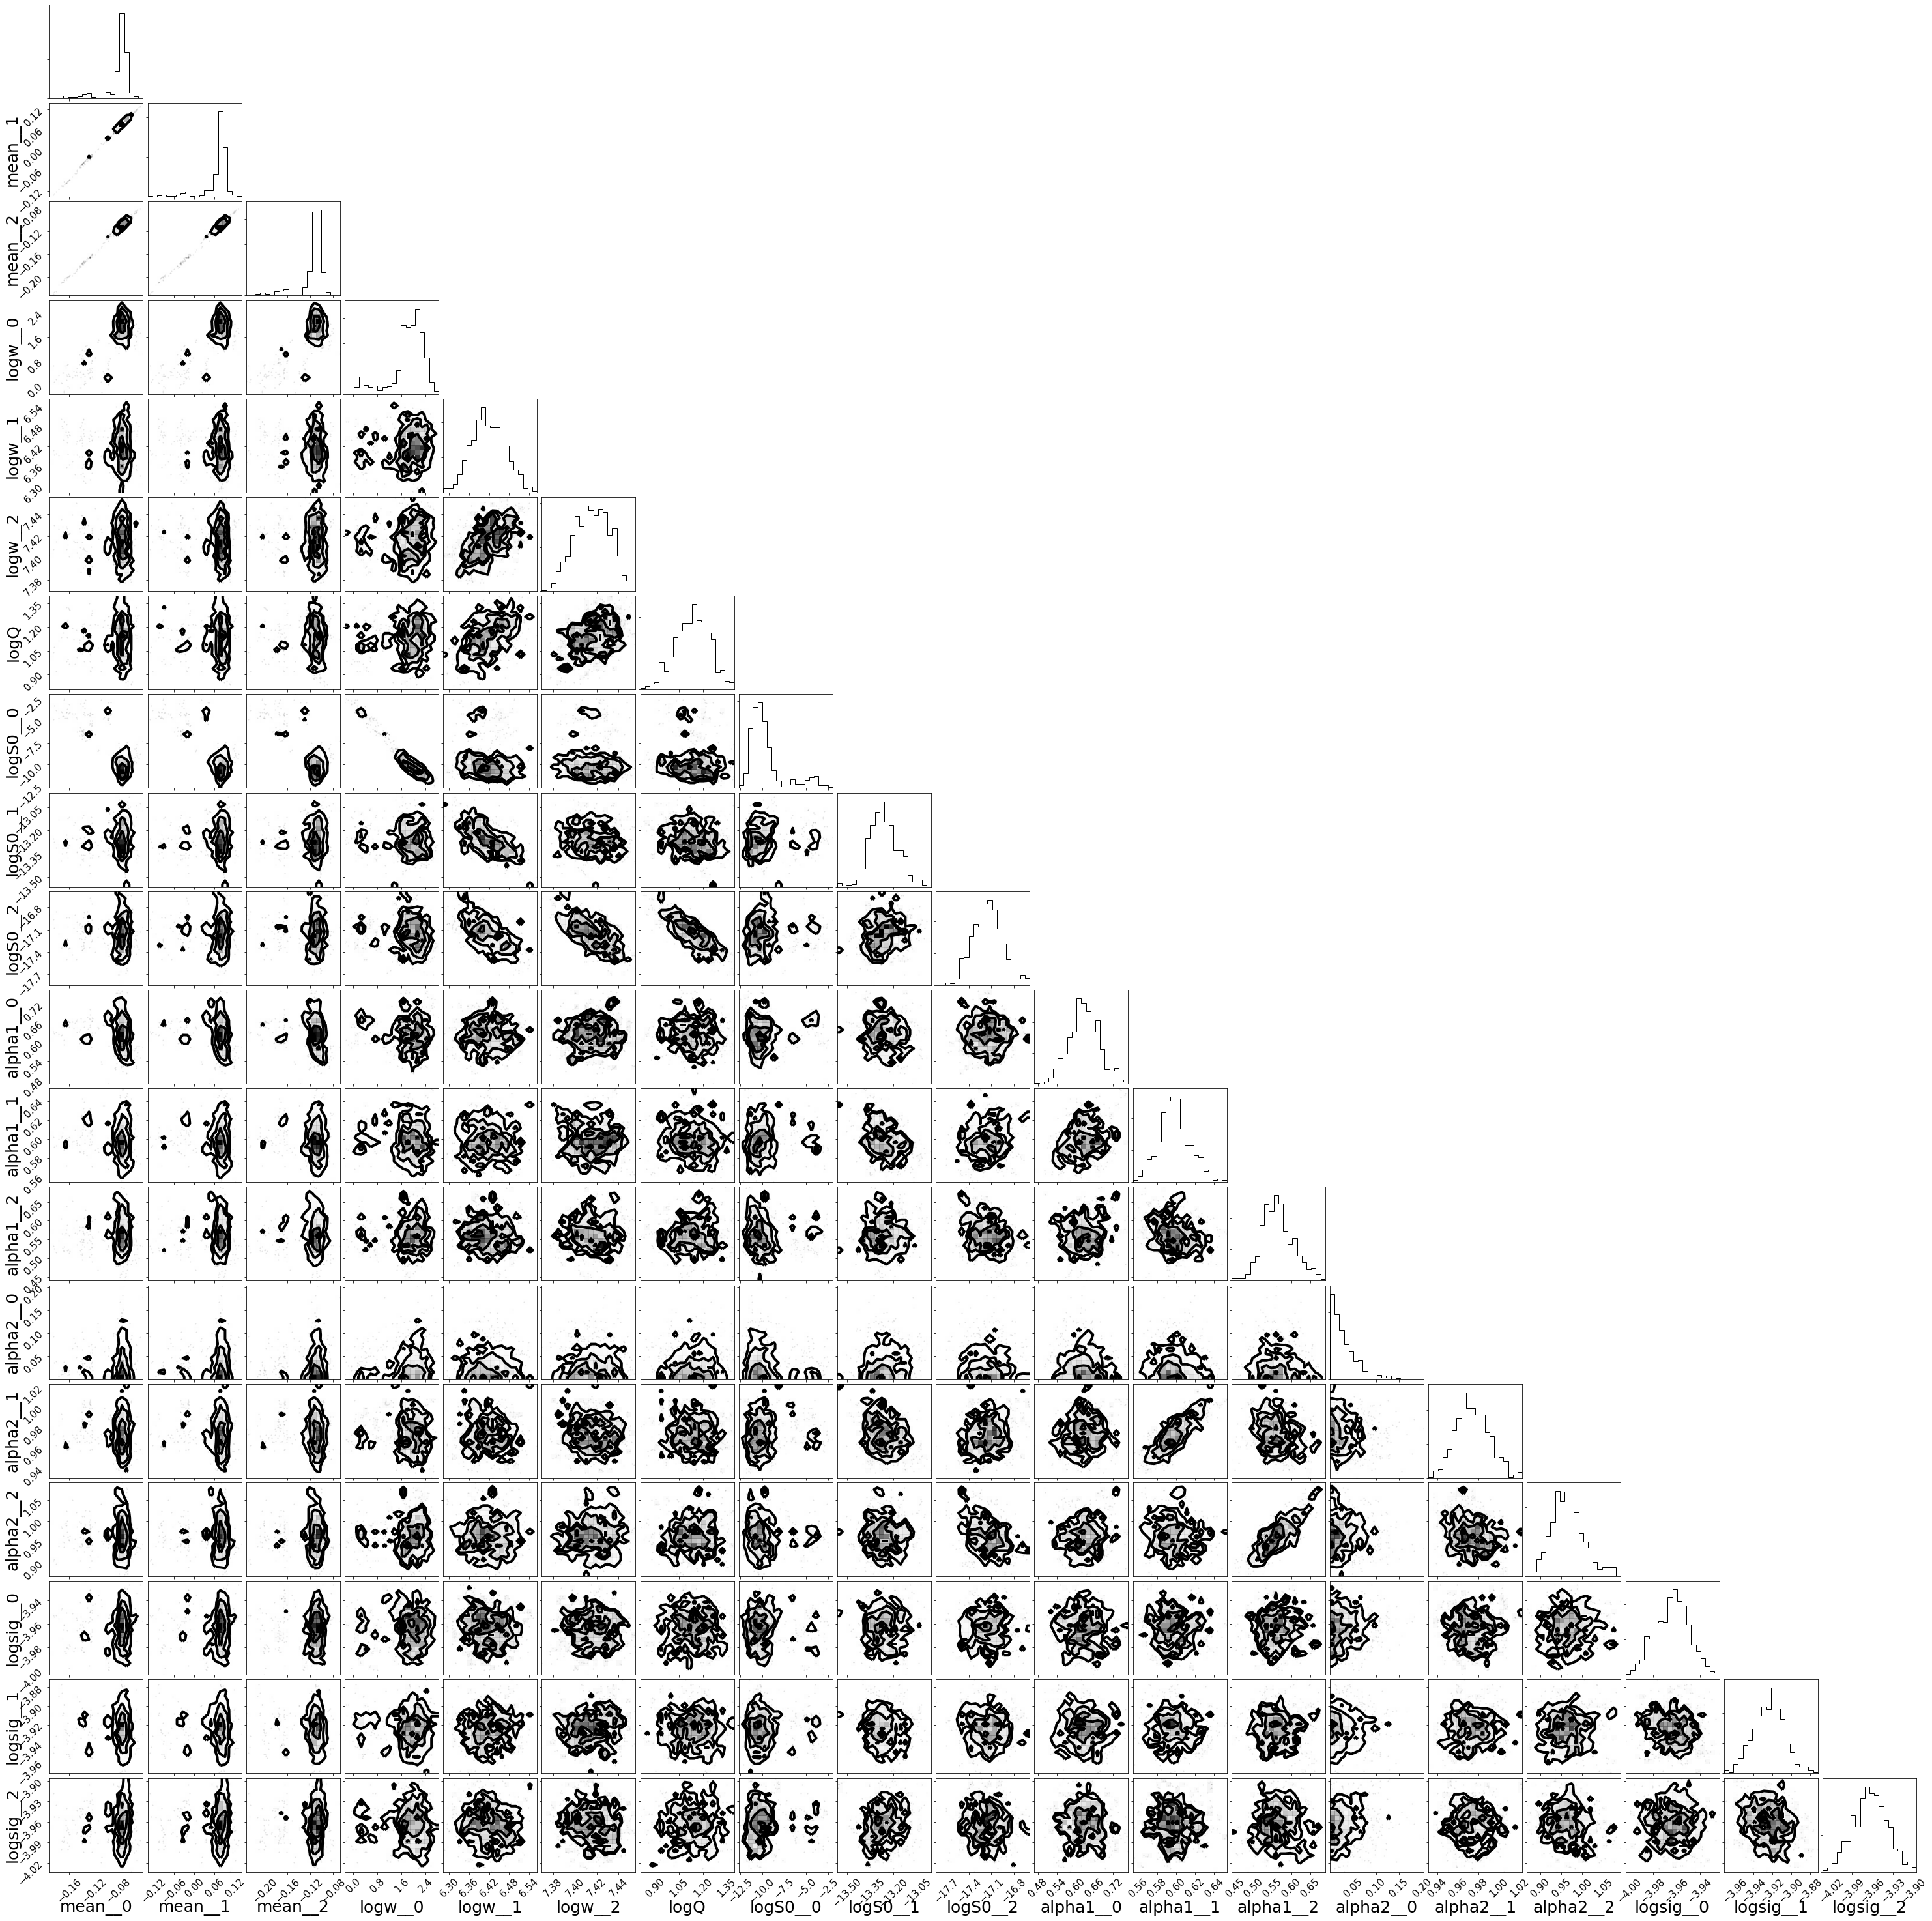

In [19]:
samples = pm.trace_to_dataframe(trace, varnames=['mean', 
                                                'logw', 
                                                'logQ',
                                                'logS0',
                                                'alpha1', 
                                                'alpha2', 
                                                'logsig'])
_ = corner.corner(samples)

In [20]:
s = [np.random.randint(len(trace)) for n in range(10)]
kernels = [get_kernel(trace[s]) for s in s]
psds = [k.psd(2*np.pi*f).T.eval() for k in kernels]

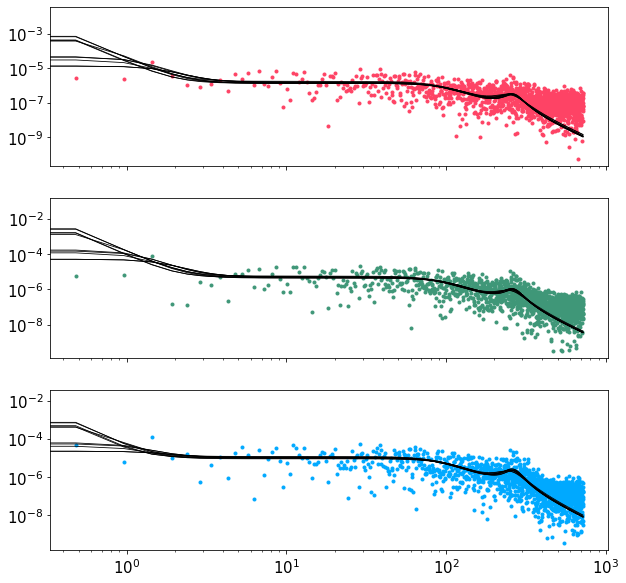

In [21]:
fig, ax = pl.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].loglog(f, powerfftr, '.', color=mpld.red)
ax[1].loglog(f, powerfftg, '.', color=mpld.green)
ax[2].loglog(f, powerfftb, '.', color=mpld.blue)

for psd in psds:
    ax[0].loglog(f, psd[0], color='k', linewidth=0.8)
    ax[1].loglog(f, psd[1], color='k', linewidth=0.8)
    ax[2].loglog(f, psd[2], color='k', linewidth=0.8)

In [22]:
m = 3
gp = xo.gp.GP(kernels[2], t, np.exp(-10)*np.ones((m, len(t))) ** 2, J=6)
z = gp.dot_l(np.random.randn(m*len(t), 1)).eval()

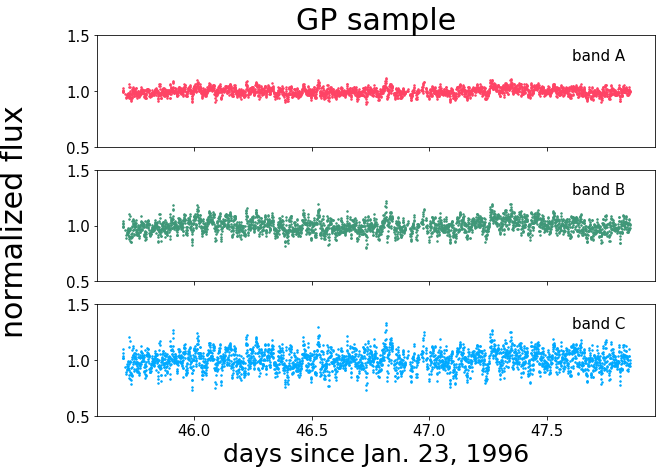

In [23]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+z[::3], '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+z[1::3], '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+z[2::3], '.', color=mpld.blue, alpha=1, ms=3.0)

ax[0].annotate('band A', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('band B', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('band C', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

ax[0].set_title("GP sample")

[ax.set_ylim(0.5, 1.5) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.3), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)
pl.savefig("/Users/tgordon/Desktop/sample.pdf")

In [ ]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+r, '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+g, '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+b, '.', color=mpld.blue, alpha=1, ms=3.0)

ax[0].annotate('862 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('500 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('402 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

ax[0].set_title("SOHO observations")

[ax.set_ylim(0.5, 1.5) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.3), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)
pl.savefig("/Users/tgordon/Desktop/spm_lc.pdf")

In [ ]:
pm.summary(trace).keys()

In [ ]:
print(pm.stats.ess(trace))

In [ ]:
tt.log(0)

In [ ]:
np.mean([r, g, b], axis=1)

In [ ]:
m = tt.as_tensor_variable([1, 2, 3])
m = m[:, None] * np.ones(10)
tt.reshape(m.T, (30,)).eval()

In [ ]:
import pymc3 as pm
with pm.Model() as model:
    
    #setattr(model, "x", pm.Uniform("x", lower=0, upper=1))
    x = pm.Uniform("x", lower=0, upper=1)
    x

In [ ]:
x